## 1. Data Loading and Understanding

In [83]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [84]:
# Load the dataset
df = pd.read_csv('StudentsPerformance.csv')

# Display basic information about the dataset
df.shape

(1000, 8)

In [85]:
# Display first few rows
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [86]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [87]:
# Statistical summary
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


## 2. Data Cleaning and Preparation

In [88]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [89]:
# Check unique values in categorical columns
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")
    print(f"Count: {len(df[col].unique())}\n")

gender: ['female' 'male']
Count: 2

race/ethnicity: ['group B' 'group C' 'group A' 'group D' 'group E']
Count: 5

parental level of education: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Count: 6

lunch: ['standard' 'free/reduced']
Count: 2

test preparation course: ['none' 'completed']
Count: 2



In [90]:
# Create new features
# AVG_SCORE = Average of math, reading, and writing scores
df['AVG_SCORE'] = (df['math score'] + df['reading score'] + df['writing score']) / 3

# AT_RISK: 1 if AVG_SCORE < 40, else 0
df['AT_RISK'] = (df['AVG_SCORE'] < 40).astype(int)

# Display the new columns
df[['math score', 'reading score', 'writing score', 'AVG_SCORE', 'AT_RISK']].head()

,math score,reading score,writing score,AVG_SCORE,AT_RISK
0,72,72,74,72.666667,0
1,69,90,88,82.333333,0
2,90,95,93,92.666667,0
3,47,57,44,49.333333,0
4,76,78,75,76.333333,0


In [91]:
# Check distribution of AT_RISK students
at_risk_counts = df['AT_RISK'].value_counts()
at_risk_counts

AT_RISK
0    970
1     30
Name: count, dtype: int64

In [92]:
# Create a copy for processing
df_processed = df.copy()

# Initialize label encoders
label_encoders = {}
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

# Encode categorical variables
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col + '_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    
# Display encoded columns
df_processed[['gender', 'gender_encoded', 'parental level of education', 'parental level of education_encoded']].head()

,gender,gender_encoded,parental level of education,parental level of education_encoded
0,female,0,bachelor's degree,1
1,female,0,some college,4
2,female,0,master's degree,3
3,male,1,associate's degree,0
4,male,1,some college,4


## 2.1 Exploratory Data Analysis

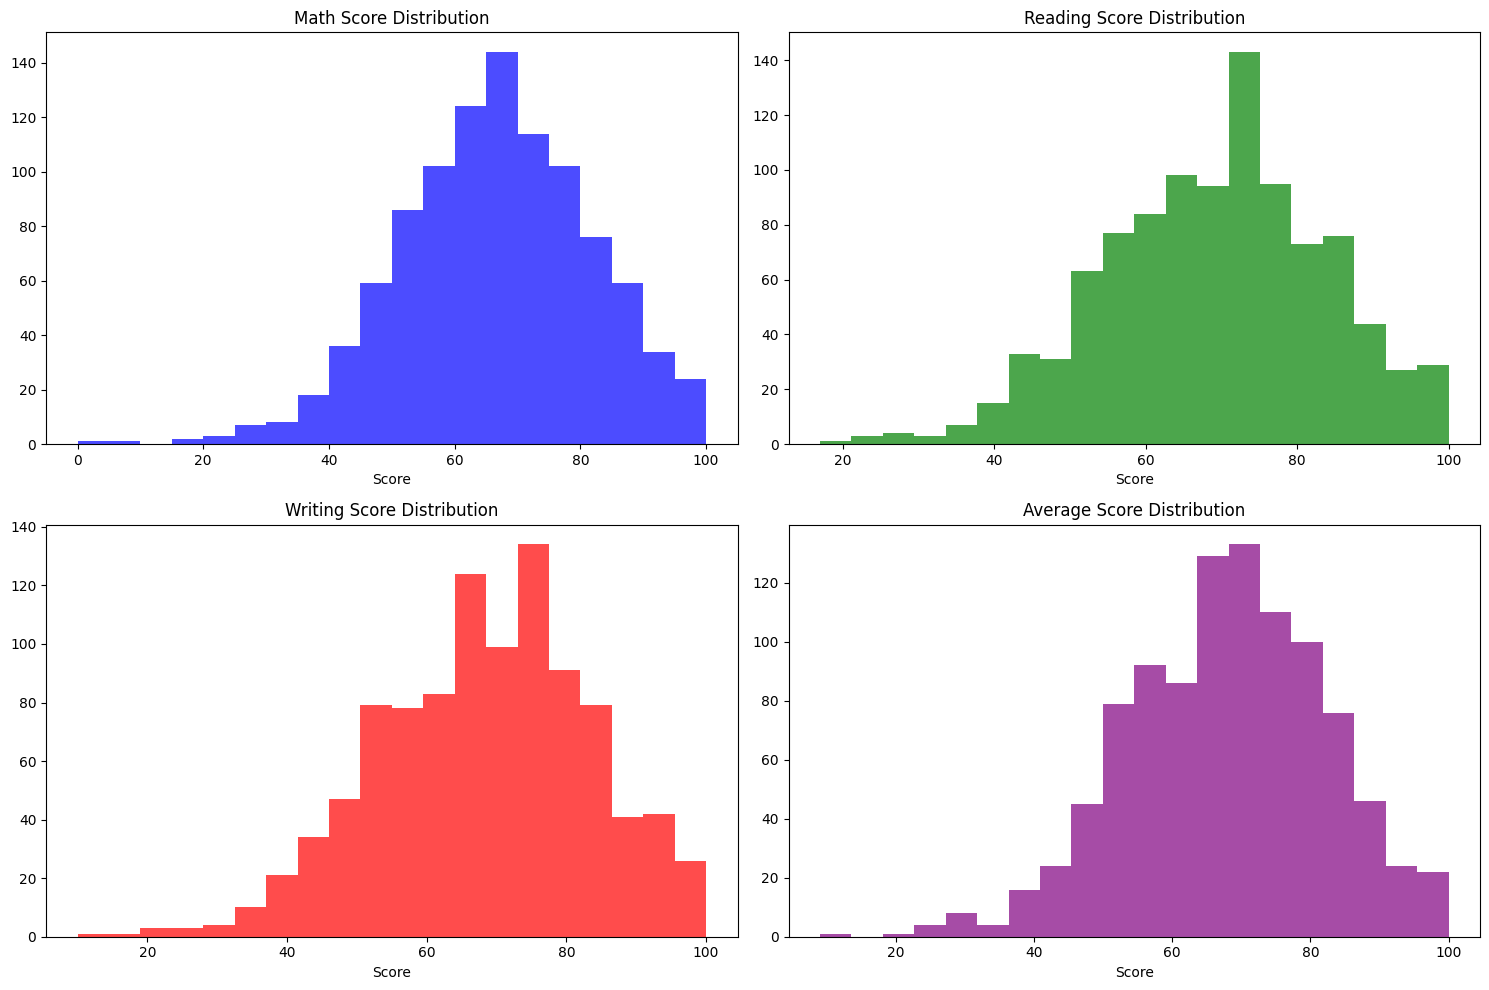

In [93]:
# Plot score distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Individual scores
axes[0,0].hist(df['math score'], bins=20, alpha=0.7, color='blue')
axes[0,0].set_title('Math Score Distribution')
axes[0,0].set_xlabel('Score')

axes[0,1].hist(df['reading score'], bins=20, alpha=0.7, color='green')
axes[0,1].set_title('Reading Score Distribution')
axes[0,1].set_xlabel('Score')

axes[1,0].hist(df['writing score'], bins=20, alpha=0.7, color='red')
axes[1,0].set_title('Writing Score Distribution')
axes[1,0].set_xlabel('Score')

axes[1,1].hist(df['AVG_SCORE'], bins=20, alpha=0.7, color='purple')
axes[1,1].set_title('Average Score Distribution')
axes[1,1].set_xlabel('Score')

plt.tight_layout()
plt.show()

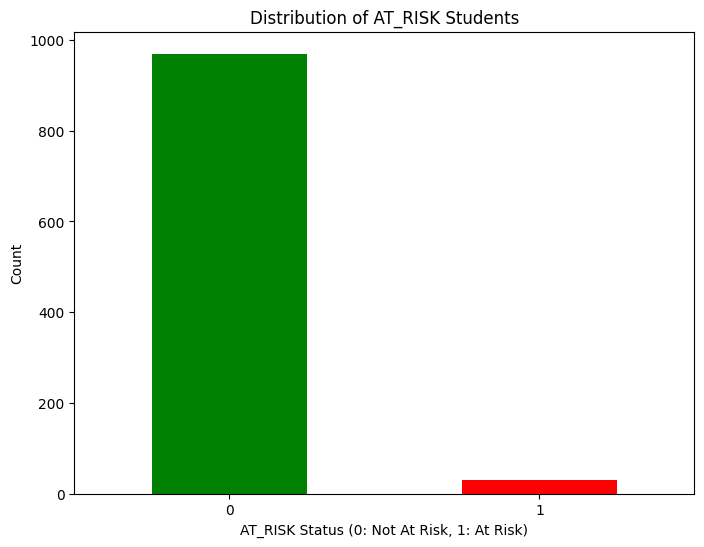

Total students: 1000
Students not at risk: 970 (97.0%)
Students at risk: 30 (3.0%)


In [94]:
# AT_RISK distribution
plt.figure(figsize=(8, 6))
at_risk_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of AT_RISK Students')
plt.xlabel('AT_RISK Status (0: Not At Risk, 1: At Risk)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Calculate percentages
total_students = len(df)
print(f"Total students: {total_students}")
print(f"Students not at risk: {at_risk_counts[0]} ({at_risk_counts[0]/total_students*100:.1f}%)")
print(f"Students at risk: {at_risk_counts[1]} ({at_risk_counts[1]/total_students*100:.1f}%)")

## 3. Model Building

In [95]:
# Prepare features for modeling
# Use encoded categorical variables and original scores
feature_cols = ['gender_encoded', 'race/ethnicity_encoded', 'parental level of education_encoded', 
                'lunch_encoded', 'test preparation course_encoded', 'math score', 'reading score', 'writing score']

X = df_processed[feature_cols]
y = df_processed['AT_RISK']

# Display feature matrix shape
X.shape

(1000, 8)

In [96]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training set AT_RISK distribution: {y_train.value_counts().values}")
print(f"Testing set AT_RISK distribution: {y_test.value_counts().values}")

Training set size: 800
Testing set size: 200
Training set AT_RISK distribution: [776  24]
Testing set AT_RISK distribution: [194   6]


In [97]:
# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 1.0000


In [98]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 1.0000


## 4. Model Evaluation

In [99]:
# Compare model accuracies
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy]
})

model_comparison

,Model,Accuracy
0,Logistic Regression,1.0
1,Random Forest,1.0


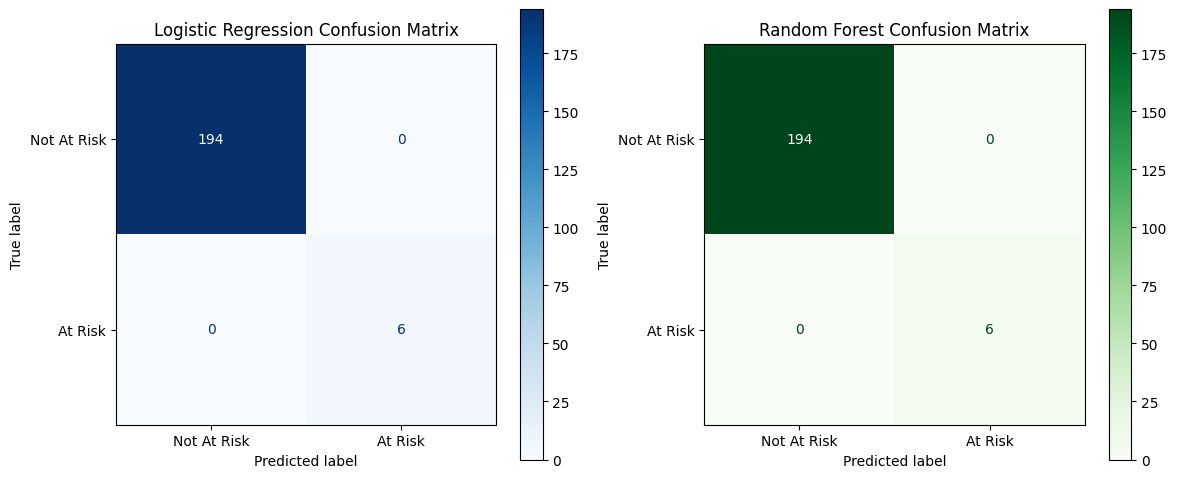

In [100]:
# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, lr_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Not At Risk', 'At Risk'])
disp_lr.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression Confusion Matrix')

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Not At Risk', 'At Risk'])
disp_rf.plot(ax=axes[1], cmap='Greens')
axes[1].set_title('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

In [101]:
# Classification reports
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred, target_names=['Not At Risk', 'At Risk']))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred, target_names=['Not At Risk', 'At Risk']))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

 Not At Risk       1.00      1.00      1.00       194
     At Risk       1.00      1.00      1.00         6

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Random Forest Classification Report:
              precision    recall  f1-score   support

 Not At Risk       1.00      1.00      1.00       194
     At Risk       1.00      1.00      1.00         6

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



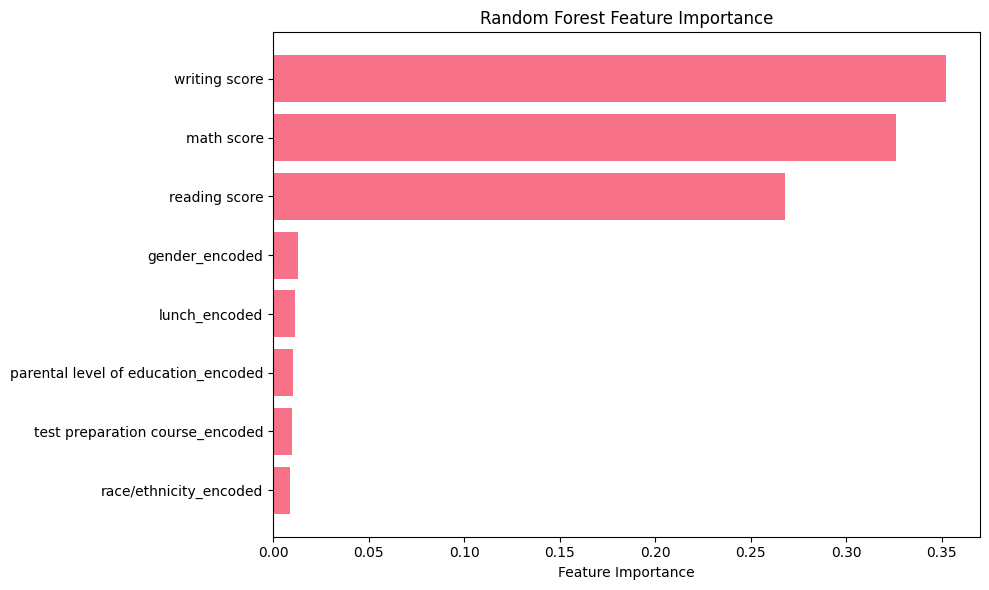

,feature,importance
7,writing score,0.352346
5,math score,0.325992
6,reading score,0.267766
0,gender_encoded,0.013044
3,lunch_encoded,0.011348
2,parental level of education_encoded,0.010563
4,test preparation course_encoded,0.010073
1,race/ethnicity_encoded,0.008868


In [102]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

feature_importance

In [103]:
# Create readable feature names for interpretation
readable_features = {
    'gender_encoded': 'Gender',
    'race/ethnicity_encoded': 'Race/Ethnicity',
    'parental level of education_encoded': 'Parental Education Level',
    'lunch_encoded': 'Lunch Type',
    'test preparation course_encoded': 'Test Prep Course',
    'math score': 'Math Score',
    'reading score': 'Reading Score', 
    'writing score': 'Writing Score'
}

# Update feature importance with readable names
feature_importance['readable_feature'] = feature_importance['feature'].map(readable_features)
top_3_features = feature_importance.head(3)

top_3_features[['readable_feature', 'importance']]

,readable_feature,importance
7,Writing Score,0.352346
5,Math Score,0.325992
6,Reading Score,0.267766


## 5. Interpretation and Ethics

In [104]:
# Analyze impact of potentially sensitive features
gender_importance = feature_importance[feature_importance['feature'] == 'gender_encoded']['importance'].values[0]
parental_ed_importance = feature_importance[feature_importance['feature'] == 'parental level of education_encoded']['importance'].values[0]

print(f"Gender importance: {gender_importance:.4f}")
print(f"Parental education importance: {parental_ed_importance:.4f}")

# Check if these are among top predictors
gender_rank = feature_importance[feature_importance['feature'] == 'gender_encoded'].index[0] + 1
parental_ed_rank = feature_importance[feature_importance['feature'] == 'parental level of education_encoded'].index[0] + 1

print(f"\nGender ranking: {gender_rank} out of {len(feature_importance)}")
print(f"Parental education ranking: {parental_ed_rank} out of {len(feature_importance)}")

Gender importance: 0.0130
Parental education importance: 0.0106

Gender ranking: 1 out of 8
Parental education ranking: 3 out of 8


In [105]:
# Explore demographic patterns
demographic_analysis = df.groupby(['gender', 'parental level of education'])['AT_RISK'].agg(['count', 'sum', 'mean']).round(3)
demographic_analysis.columns = ['Total_Students', 'At_Risk_Count', 'At_Risk_Rate']
demographic_analysis

Total_Students  At_Risk_Count  \
gender parental level of education                                  
female associate's degree                      116              1   
       bachelor's degree                        63              1   
       high school                              94              5   
       master's degree                          36              0   
       some college                            118              3   
       some high school                         91              6   
male   associate's degree                      106              1   
       bachelor's degree                        55              1   
       high school                             102              5   
       master's degree                          23              0   
       some college                            108              3   
       some high school                         88              4   

                                    At_Risk_Rate  
gender parental level of education                
female associate's degree                  0.009  
       bachelor's degree                   0.016  
       high school                         0.053  
       master's degree                     0.000  
       some college                        0.025  
       some high school                    0.066  
male   associate's degree                  0.009  
       bachelor's degree                   0.018  
       high school                         0.049  
       master's degree                     0.000  
       some college                        0.028  
       some high school                    0.045

### Question 1: How many students passed, failed, or dropped out?

In [106]:
student_performance = df['AT_RISK'].value_counts()
total = len(df)

print(f"Students performing well: {student_performance[0]} ({student_performance[0]/total*100:.1f}%)")
print(f"Students at risk: {student_performance[1]} ({student_performance[1]/total*100:.1f}%)")

Students performing well: 970 (97.0%)
Students at risk: 30 (3.0%)


### Question 2: Which model performs better on accuracy?

In [107]:
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Logistic Regression Accuracy: 1.0000
Random Forest Accuracy: 1.0000


### Question 3: Which 3 features most influence success?

In [108]:
for i, (_, row) in enumerate(top_3_features.iterrows(), 1):
    print(f"{i}. {row['readable_feature']}: {row['importance']:.4f}")

1. Writing Score: 0.3523
2. Math Score: 0.3260
3. Reading Score: 0.2678


### Question 4: What features most influenced the student's predicted outcome?

In [109]:
for i, (_, row) in enumerate(feature_importance.iterrows(), 1):
    print(f"{i}. {row['readable_feature']}: {row['importance']:.4f}")

1. Writing Score: 0.3523
2. Math Score: 0.3260
3. Reading Score: 0.2678
4. Gender: 0.0130
5. Lunch Type: 0.0113
6. Parental Education Level: 0.0106
7. Test Prep Course: 0.0101
8. Race/Ethnicity: 0.0089


### Question 5: Should Gender or Parental Education Be Used in Decisions?

- Gender accounts for only 1.30% of the model's decision-making
- Parental education accounts for only 1.06% 
- Combined, they represent less than 2.4% of the total influence
- Academic scores (Writing, Math, Reading) account for 94.61% of predictions


### Question 6: Propose one way this model could help support struggling students

In [110]:
students_needing_support = df[df['AT_RISK'] == 1]

intervention_analysis = students_needing_support.groupby('test preparation course')['AVG_SCORE'].agg(['count', 'mean']).round(2)
intervention_analysis.columns = ['Count', 'Avg_Score']

intervention_analysis

,Count,Avg_Score
test preparation course,,
completed,3,37.22
none,27,31.78
